In [4]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:

df = pd.read_csv('../Data/MSFT_historical_data_yfinance.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
#show the data
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-12-13,31.509763,31.535026,30.836118,30.895061,40066100
2013-12-16,30.928732,31.156088,30.768743,31.063461,31734200
2013-12-17,31.105562,31.248713,30.591910,30.751900,45687700
2013-12-18,30.617180,30.819271,29.918271,30.802433,63192100
2013-12-19,30.743483,30.777166,30.381401,30.524549,34160100
...,...,...,...,...,...
2023-12-07,368.230011,371.450012,366.320007,370.950012,23118900
2023-12-08,369.200012,374.459991,368.230011,374.230011,20144800
2023-12-11,368.480011,371.600006,366.100006,371.299988,27708800


In [6]:
#get the number of rounds and columns in the data set
df.shape

(2517, 5)

<function matplotlib.pyplot.show(close=None, block=None)>

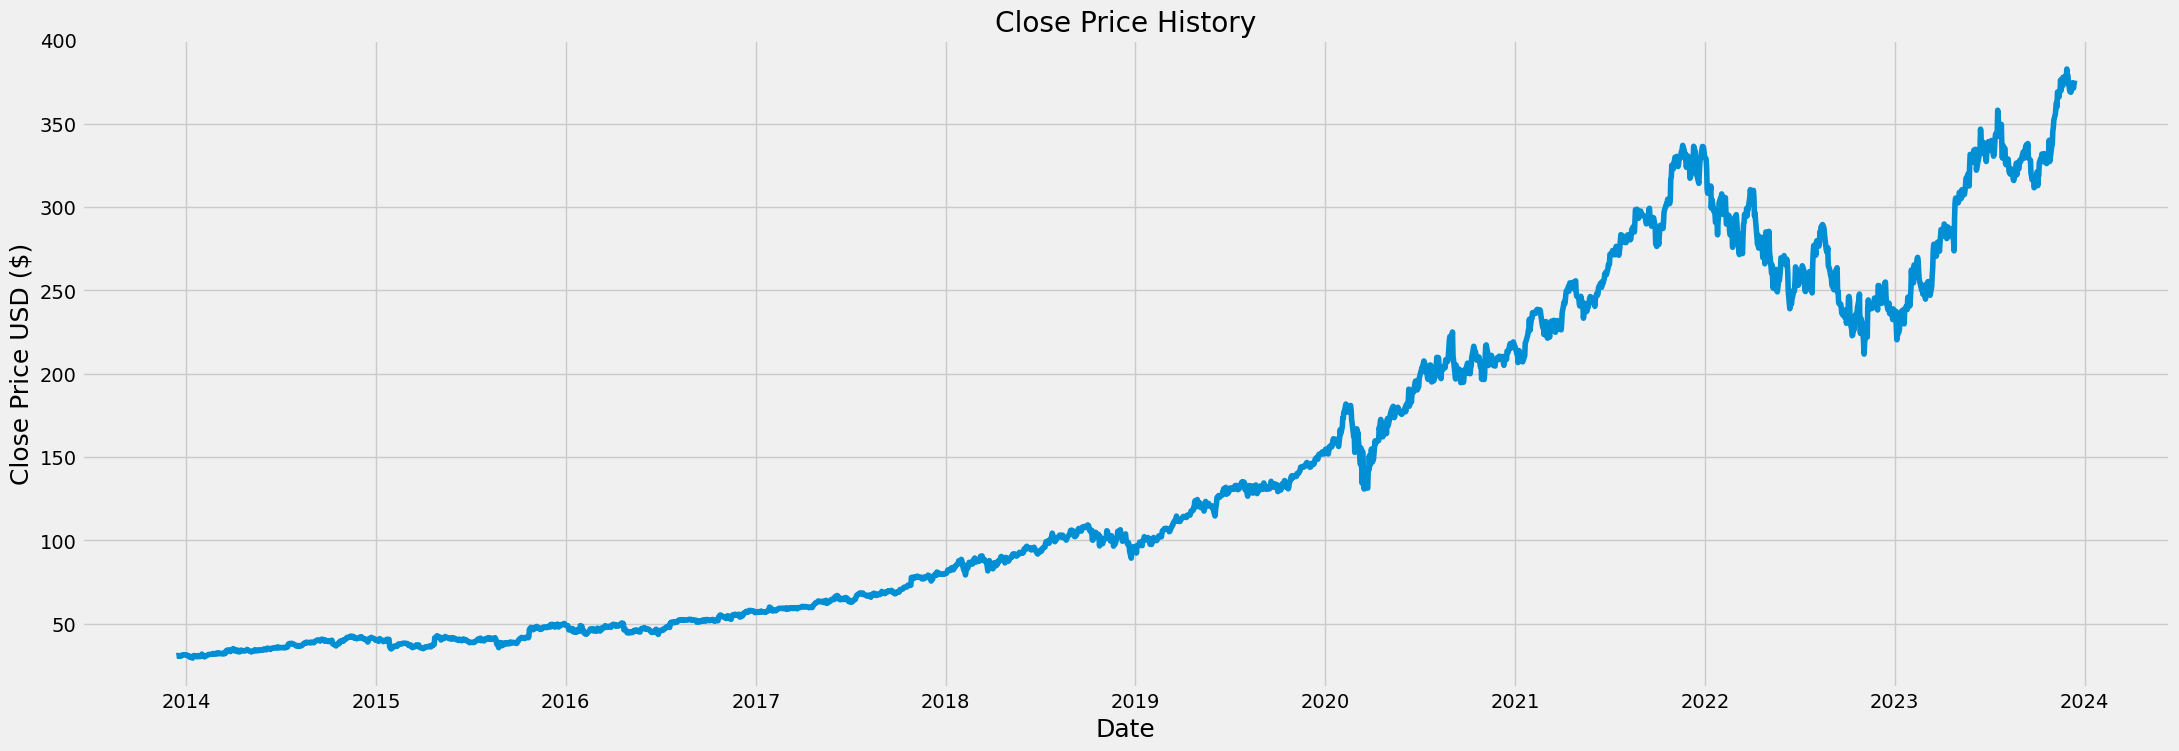

In [7]:
#visualize the closing stock price history
plt.figure(figsize = (24,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show

In [8]:
#create a new data frame with only "Close" column
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8795)
training_data_len

2214

In [9]:
#scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00407628],
       [0.00455301],
       [0.00367101],
       ...,
       [0.9677277 ],
       [0.97644691],
       [0.98069378]])

In [10]:
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x-train and y-train dataset
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00407628, 0.00455301, 0.00367101, 0.00381406, 0.0030274 ,
       0.0043385 , 0.0039094 , 0.00500595, 0.00586408, 0.00550653,
       0.00550653, 0.00579256, 0.00519665, 0.00460068, 0.00274131,
       0.00340879, 0.00185935, 0.00131108, 0.00252681, 0.        ,
       0.00190702, 0.00424307, 0.00455301, 0.0033373 , 0.0028367 ,
       0.0022646 , 0.0025745 , 0.00436232, 0.00250297, 0.00307508,
       0.00400475, 0.0044815 , 0.00681764, 0.00357565, 0.00326577,
       0.00200238, 0.00286054, 0.00376637, 0.0043385 , 0.00522048,
       0.00593561, 0.00626935, 0.0062932 , 0.00648531, 0.00670145,
       0.00727781, 0.00783023, 0.00713374, 0.00677352, 0.00660541,
       0.00754202, 0.00862279, 0.00734991, 0.00886294, 0.0081424 ,
       0.00823848, 0.00763812, 0.00744595, 0.00792631, 0.0085267 ])]
[0.007614094984369782]

[array([0.00407628, 0.00455301, 0.00367101, 0.00381406, 0.0030274 ,
       0.0043385 , 0.0039094 , 0.00500595, 0.00586408, 0.00550653,
       0.00550653, 0.00579256, 0.0

In [11]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2154, 60, 1)

In [13]:
x_val = []
y_val = []
for i in range(training_data_len, len(scaled_data)-52):
    x_val.append(scaled_data[i-60:i, 0])
    y_val.append(scaled_data[i, 0])

# Convert the x_val and y_val to numpy arrays
x_val, y_val = np.array(x_val), np.array(y_val)

# Reshape the validation data
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))


In [14]:
#build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
#compile the model
model.compile(optimizer ='adam', loss = 'mean_squared_error')

In [16]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=30, epochs=50)


Epoch 1/50


72/72 [==============================] - 6s 44ms/step - loss: 0.0108 - val_loss: 7.8920e-04
Epoch 2/50
72/72 [==============================] - 2s 29ms/step - loss: 2.5948e-04 - val_loss: 7.2403e-04
Epoch 3/50
72/72 [==============================] - 2s 28ms/step - loss: 2.4818e-04 - val_loss: 7.8779e-04
Epoch 4/50
72/72 [==============================] - 2s 28ms/step - loss: 2.5035e-04 - val_loss: 7.1106e-04
Epoch 5/50
72/72 [==============================] - 2s 28ms/step - loss: 2.6789e-04 - val_loss: 7.6234e-04
Epoch 6/50
72/72 [==============================] - 2s 27ms/step - loss: 2.3542e-04 - val_loss: 0.0015
Epoch 7/50
72/72 [==============================] - 2s 27ms/step - loss: 2.5328e-04 - val_loss: 8.6407e-04
Epoch 8/50
72/72 [==============================] - 2s 27ms/step - loss: 2.2703e-04 - val_loss: 6.6147e-04
Epoch 9/50
72/72 [==============================] - 2s 27ms/step - loss: 2.2902e-04 - val_loss: 6.4894e-04
Epoch 10/50
72/72 [==============================] - 2s 

In [17]:
#create the testing data set
#create a new array containing scaled values from index 2013 to 2591
test_data = scaled_data[training_data_len + 191 : , :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len + 251 : , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
#convert the data to a numpy array
x_test = np.array(x_test)
len(y_test)

52

In [18]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))


In [19]:
#get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 11ms/step


In [20]:
#get the root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

4.337417351723402

In [21]:
y_val_predict = model.predict(x_val)
y_val_predict = scaler.inverse_transform(y_val_predict)

8/8 [==============================] - 0s 11ms/step


/tmp/ipykernel_56832/1707649326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid ['Predictions'] = y_val_predict


<function matplotlib.pyplot.show(close=None, block=None)>

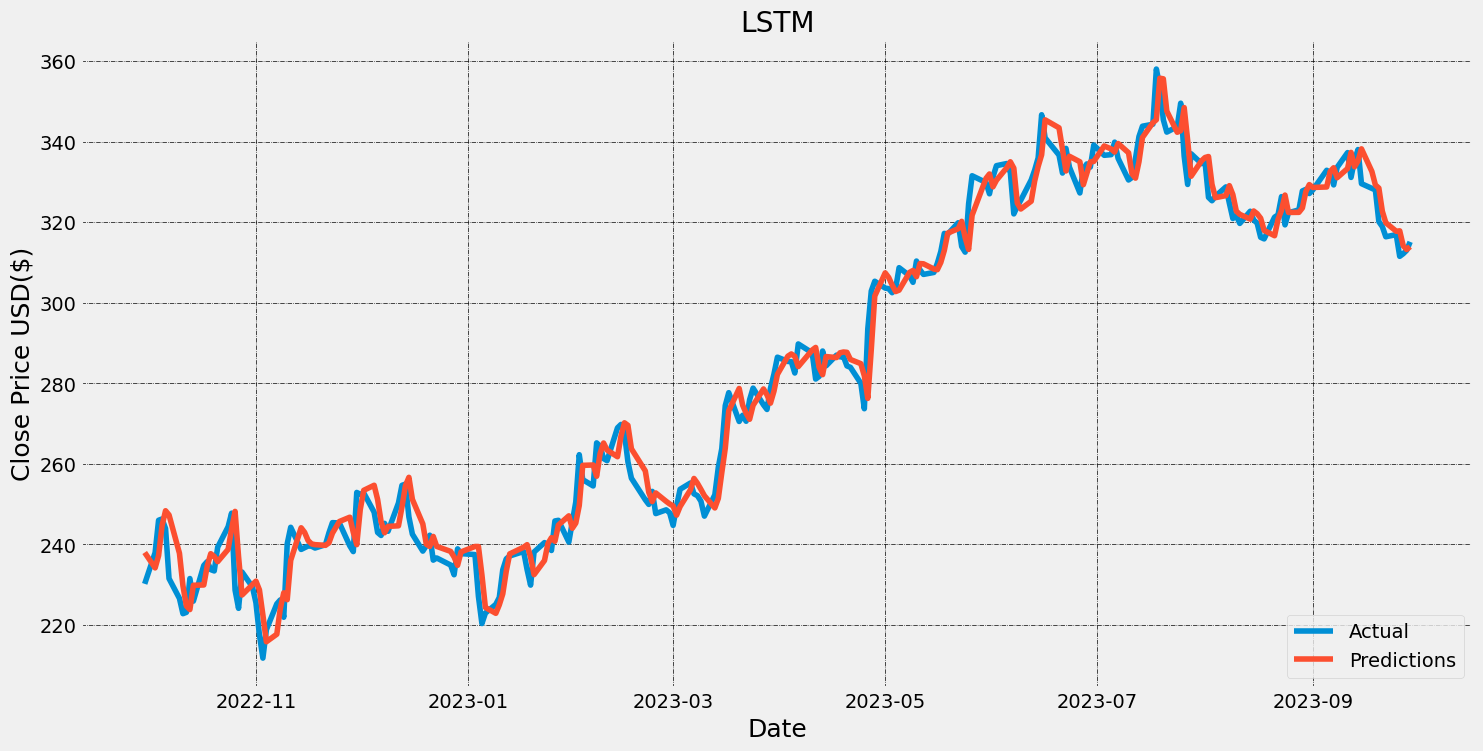

In [22]:
train = data[:training_data_len]
valid = data[training_data_len:-52]
valid ['Predictions'] = y_val_predict
#visualize the data
plt.figure(figsize = (16,8))
plt.title('LSTM')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
# plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.grid(which='major',color='k', linestyle='-.',linewidth=0.5)
plt.legend(['Actual', 'Predictions'], loc = 'lower right')
plt.show

In [23]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate R-squared and explained variance
y_true = y_test
y_pred = predictions
explained_variance = r2_score(y_true, y_pred)
test_r_squared = explained_variance
test_explain_variation = explained_variance * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
test_mape = mape * 100

# Calculate other metrics (optional)
test_mae = mean_absolute_error(y_true, y_pred)
test_mse = mean_squared_error(y_true, y_pred)
test_rmse = np.sqrt(test_mse)

# Print test metrics
print(f"Test R-squared: {test_r_squared}")
print(f"Test MAPE: {test_mape}%")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")


2/2 [==============================] - 0s 10ms/step
Test R-squared: 0.9606062604619547
Test MAPE: 1.0153959068551754%
Test MSE: 18.81318928303125
Test RMSE: 4.337417351723402
Test MAE: 3.5387332622821526


In [24]:
valid

,Close,Predictions
Date,,
2022-09-30,230.204285,237.987991
2022-10-03,237.953552,234.166626
2022-10-04,245.999344,237.221161
2022-10-05,246.315613,244.706467
2022-10-06,243.933533,248.358887
...,...,...
2023-09-25,316.896820,317.736511
2023-09-26,311.507751,317.837738
2023-09-27,312.156433,314.148407


In [25]:
csv_file_path='/content/drive/MyDrive/Colab Notebooks/LSTM_Validation1.csv'
valid.to_csv(csv_file_path, index= False)

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab Notebooks'